In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = datasets.MNIST(root='../input/data',train=True,download=True,transform=transforms.ToTensor())
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_data = datasets.MNIST(root='../input/data',train=False,download=True,transform=transforms.ToTensor())
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle=False)

Extracting ../input/data/MNIST/raw/train-images-idx3-ubyte.gz to ../input/data/MNIST/raw


Extracting ../input/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/data/MNIST/raw


Extracting ../input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/data/MNIST/raw


Extracting ../input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class VAE(nn.Module):
  def __init__(self,in_dim = 784,z_dim = 20):
    super(VAE, self).__init__()

    self.z_dim = z_dim

    self.encoder = nn.Sequential(
        nn.Linear(in_dim,in_dim//4),
        nn.ReLU(inplace=True),
        nn.Linear(in_dim//4,in_dim//16),
        nn.ReLU(inplace=True),
        nn.Linear(in_dim//16,z_dim*2),
    )
    self.decoder = nn.Sequential(
        nn.Linear(z_dim,z_dim*4),
        nn.Linear(z_dim*4,z_dim*16),
        nn.Linear(z_dim*16,in_dim),
        nn.Sigmoid(),
    )

  def forward(self,x):
    x=x.view(x.size(0),-1)
    x = self.encoder(x)
    x = x.view(-1, 2, self.z_dim)
    mu = x[:,0,:]
    log_sigma = x[:,1,:]
    z = mu + torch.randn_like(mu) * torch.exp(log_sigma) 
    x_hat = self.decoder(z)
    return x_hat , mu , log_sigma

In [ ]:
def criterion(x_hat,mu,log_sigma,x):
  l_rec = L_recon(x_hat,x)
  l_reg = torch.sum(0.5*(torch.exp(log_sigma)**2 + mu**2 - 1 - 2*log_sigma))
  return l_rec + l_reg

def display_images(x,x_hat,batch_size):
  n = int(np.sqrt(batch_size))
  fig ,axs = plt.subplots(2*n,n, figsize = (15,15))
  x_copy = np.squeeze(x.clone().detach().cpu().numpy())
  x_hat_copy = np.squeeze(x_hat.clone().detach().cpu().numpy())
  
  for i in range(n):
    for j in range(n):
      if len(x.shape)==1:
        axs[i,j].imshow(x_copy[i*n+j].reshape(28,28),cmap='gray')
        axs[i+n,j].imshow(x_hat_copy[i*n+j].reshape(28,28),cmap='gray')
      else:
        axs[i,j].imshow(x_copy[i*n+j],cmap='gray')
        axs[i+n,j].imshow(x_hat_copy[i*n+j],cmap='gray')

      axs[i,j].axis('off')
      axs[i+n,j].axis('off')
    
  plt.axis('off')
  plt.show()

def train_model(model):
  avg_loss = 0
  model.train()
  for i, (x,_) in enumerate(train_loader):
    optimizer.zero_grad()
    x = x.to(device)
    x_hat , mu , log_sigma = model(x)

    ###########################
    if i==0 and epoch%10==0:
      display_images(x,x_hat,batch_size)
    ###########################
    loss = criterion(x_hat,mu,log_sigma,x)
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()
  return avg_loss/len(train_loader.dataset)


def validate(model):
  avg_loss = 0
  model.eval()
  with torch.no_grad():
    for x,_ in val_loader:
      x = x.to(device)
      x_hat , mu , sigma = model(x)
      loss = criterion(x_hat,mu,sigma,x)
      avg_loss += loss.data.item()
  
  avg_loss/= len(val_loader.dataset)
  global min_loss 
  global j 
  
  if min_loss > avg_loss:
    min_loss = avg_loss
    print('\nMin Loss:{:.4f}'.format(min_loss))
    torch.save(model.state_dict(), f'{path}/model_{type(model).__name__}.pth')
    print('model saved')
    j=1
  else:
    j+=1
    if j==5:
      j=1
      scheduler.step()
      for param_group in optimizer.param_groups:
            print("Current learning rate is: {}".format(param_group['lr']))  

  return avg_loss

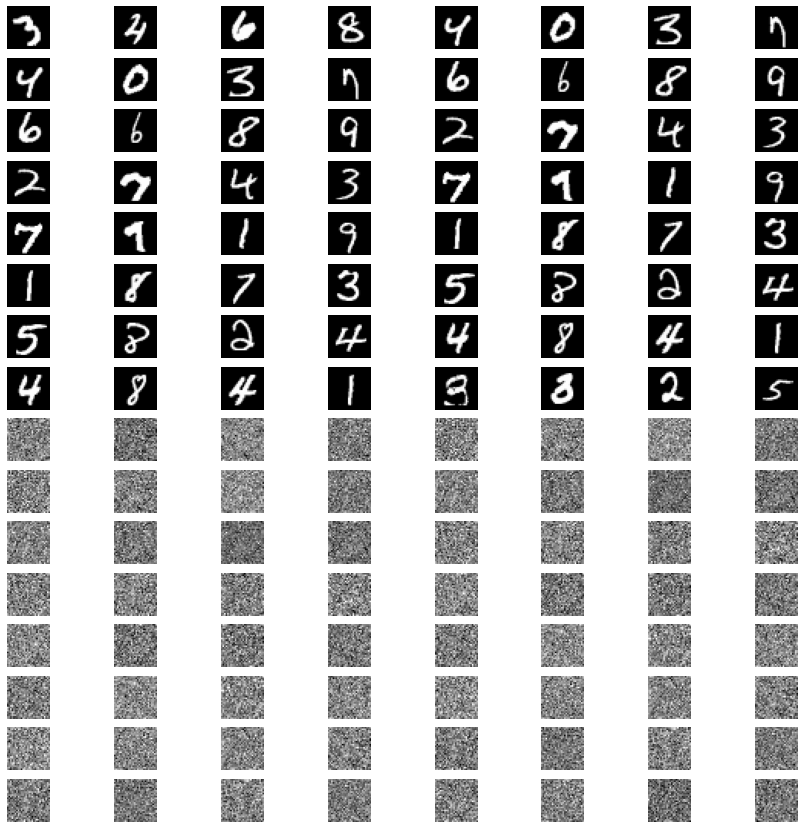


Min Loss:199.2968
model saved
Epoch : 0 
Train loss : 236.133075 
Validation loss : 199.296771

Min Loss:173.2410
model saved
Epoch : 1 
Train loss : 187.147577 
Validation loss : 173.241005

Min Loss:158.8703
model saved
Epoch : 2 
Train loss : 167.451955 
Validation loss : 158.870331

Min Loss:151.9123
model saved
Epoch : 3 
Train loss : 156.217352 
Validation loss : 151.912314

Min Loss:145.6560
model saved
Epoch : 4 
Train loss : 149.322053 
Validation loss : 145.655986

Min Loss:142.0115
model saved
Epoch : 5 
Train loss : 144.686653 
Validation loss : 142.011451

Min Loss:139.0100
model saved
Epoch : 6 
Train loss : 141.779689 
Validation loss : 139.010016

Min Loss:137.2888
model saved
Epoch : 7 
Train loss : 139.319250 
Validation loss : 137.288829

Min Loss:135.4491
model saved
Epoch : 8 
Train loss : 137.532448 
Validation loss : 135.449080

Min Loss:134.4069
model saved
Epoch : 9 
Train loss : 136.013260 
Validation loss : 134.406940


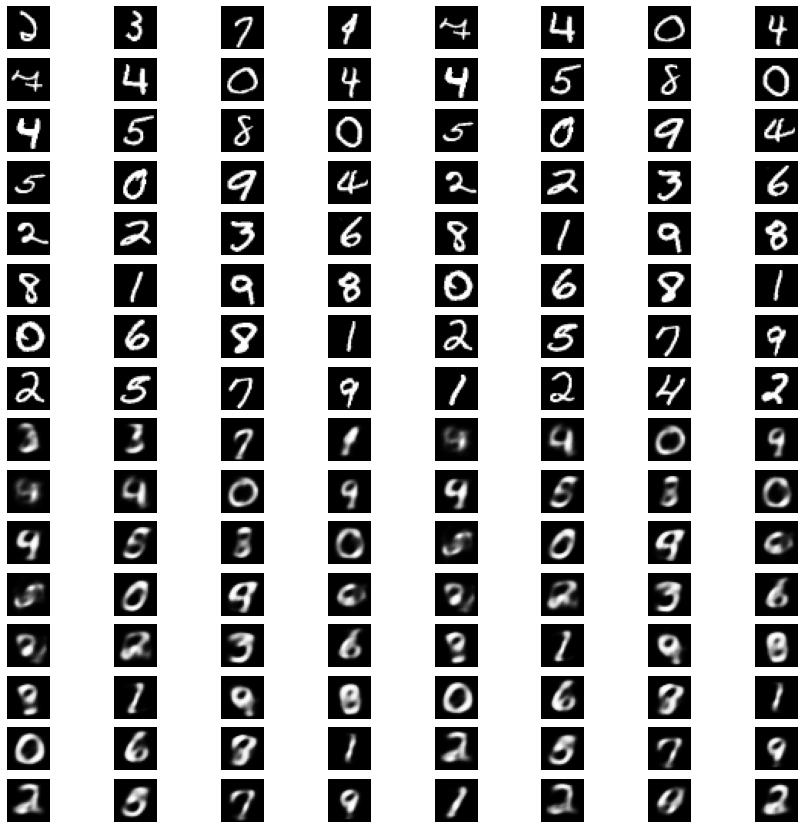


Min Loss:133.7569
model saved
Epoch : 10 
Train loss : 135.228976 
Validation loss : 133.756889

Min Loss:133.2638
model saved
Epoch : 11 
Train loss : 134.605769 
Validation loss : 133.263762

Min Loss:131.4323
model saved
Epoch : 12 
Train loss : 133.645628 
Validation loss : 131.432331

Min Loss:129.8094
model saved
Epoch : 13 
Train loss : 131.784838 
Validation loss : 129.809405

Min Loss:128.7149
model saved
Epoch : 14 
Train loss : 130.410738 
Validation loss : 128.714859

Min Loss:128.1624
model saved
Epoch : 15 
Train loss : 129.699523 
Validation loss : 128.162408

Min Loss:127.7259
model saved
Epoch : 16 
Train loss : 129.277679 
Validation loss : 127.725867

Min Loss:127.4490
model saved
Epoch : 17 
Train loss : 128.909617 
Validation loss : 127.449000

Min Loss:127.1709
model saved
Epoch : 18 
Train loss : 128.513838 
Validation loss : 127.170875

Min Loss:126.8354
model saved
Epoch : 19 
Train loss : 128.233637 
Validation loss : 126.835440


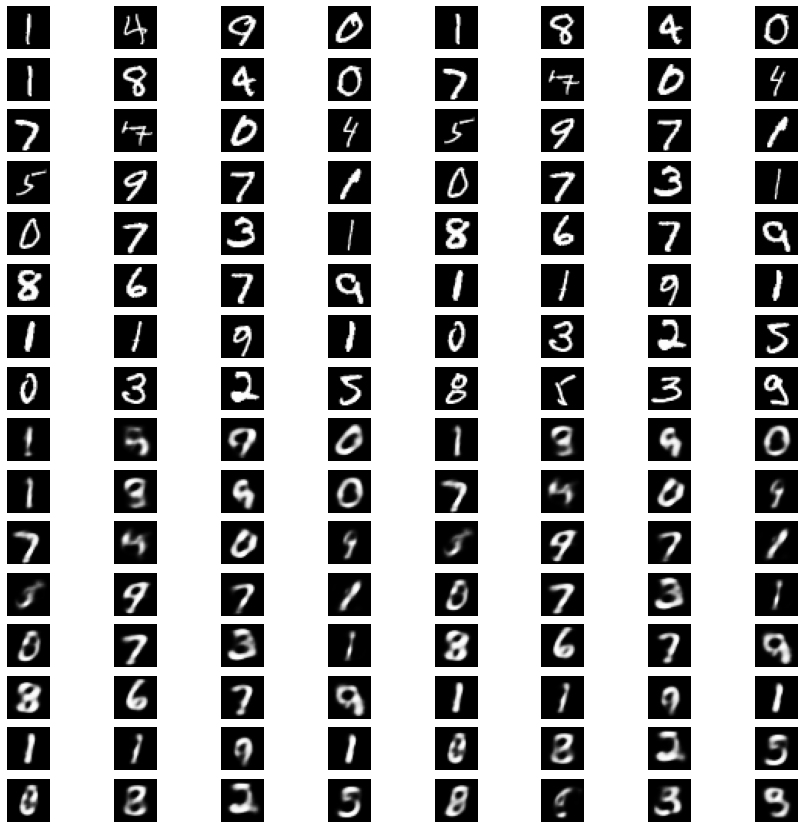


Min Loss:126.5656
model saved
Epoch : 20 
Train loss : 127.943292 
Validation loss : 126.565624

Min Loss:126.2116
model saved
Epoch : 21 
Train loss : 127.693445 
Validation loss : 126.211605

Min Loss:125.8168
model saved
Epoch : 22 
Train loss : 127.267880 
Validation loss : 125.816770

Min Loss:124.7565
model saved
Epoch : 23 
Train loss : 126.521650 
Validation loss : 124.756512

Min Loss:124.3854
model saved
Epoch : 24 
Train loss : 125.784666 
Validation loss : 124.385445

Min Loss:124.0331
model saved
Epoch : 25 
Train loss : 125.429680 
Validation loss : 124.033120

Min Loss:123.7299
model saved
Epoch : 26 
Train loss : 125.189500 
Validation loss : 123.729852

Min Loss:123.5697
model saved
Epoch : 27 
Train loss : 124.957810 
Validation loss : 123.569723

Min Loss:123.3722
model saved
Epoch : 28 
Train loss : 124.758551 
Validation loss : 123.372196

Min Loss:123.1712
model saved
Epoch : 29 
Train loss : 124.558361 
Validation loss : 123.171181


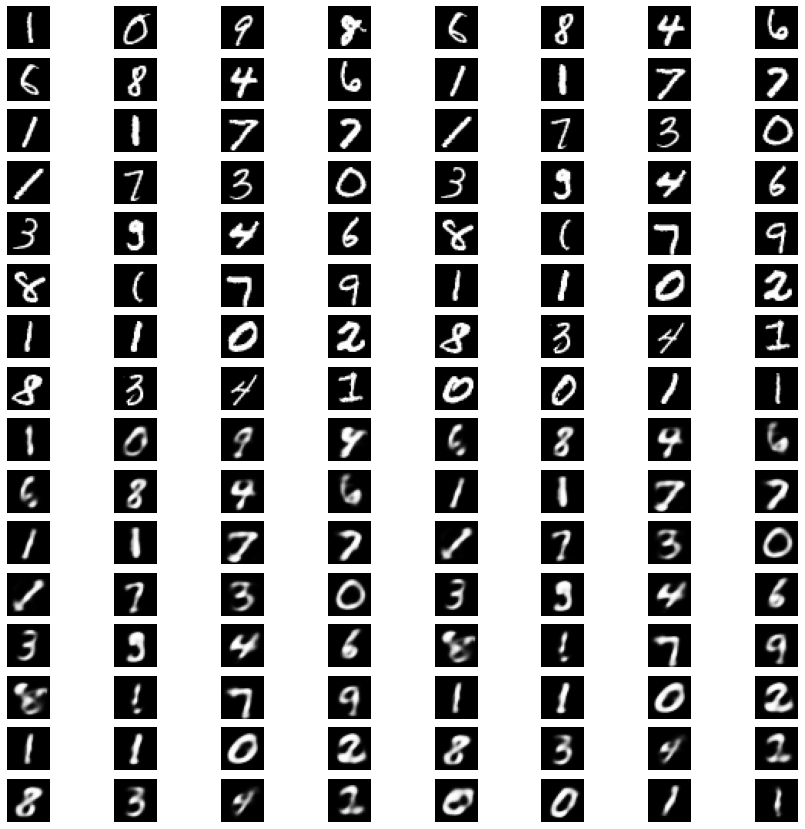


Min Loss:123.0576
model saved
Epoch : 30 
Train loss : 124.394385 
Validation loss : 123.057619

Min Loss:122.8214
model saved
Epoch : 31 
Train loss : 124.229504 
Validation loss : 122.821411

Min Loss:122.8101
model saved
Epoch : 32 
Train loss : 124.148387 
Validation loss : 122.810107

Min Loss:122.7731
model saved
Epoch : 33 
Train loss : 124.039756 
Validation loss : 122.773117

Min Loss:122.6219
model saved
Epoch : 34 
Train loss : 124.003315 
Validation loss : 122.621856

Min Loss:122.5845
model saved
Epoch : 35 
Train loss : 123.942934 
Validation loss : 122.584510
Epoch : 36 
Train loss : 123.860071 
Validation loss : 122.585341

Min Loss:122.4747
model saved
Epoch : 37 
Train loss : 123.833795 
Validation loss : 122.474670
Epoch : 38 
Train loss : 123.774491 
Validation loss : 122.540624

Min Loss:122.3541
model saved
Epoch : 39 
Train loss : 123.722529 
Validation loss : 122.354085


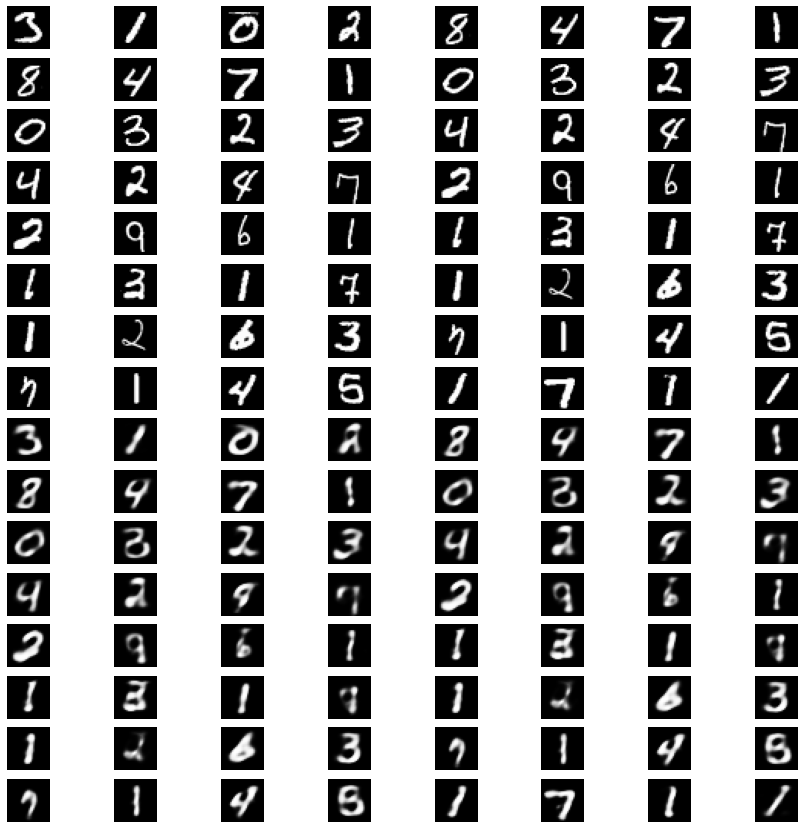


Min Loss:122.3346
model saved
Epoch : 40 
Train loss : 123.691975 
Validation loss : 122.334612
Epoch : 41 
Train loss : 123.631938 
Validation loss : 122.403383

Min Loss:122.2875
model saved
Epoch : 42 
Train loss : 123.630210 
Validation loss : 122.287452
Epoch : 43 
Train loss : 123.609839 
Validation loss : 122.325998

Min Loss:122.2728
model saved
Epoch : 44 
Train loss : 123.545542 
Validation loss : 122.272781
Epoch : 45 
Train loss : 123.540657 
Validation loss : 122.276825

Min Loss:122.2431
model saved
Epoch : 46 
Train loss : 123.457047 
Validation loss : 122.243110

Min Loss:122.2082
model saved
Epoch : 47 
Train loss : 123.452635 
Validation loss : 122.208220
Epoch : 48 
Train loss : 123.416532 
Validation loss : 122.222250

Min Loss:122.1669
model saved
Epoch : 49 
Train loss : 123.412137 
Validation loss : 122.166854


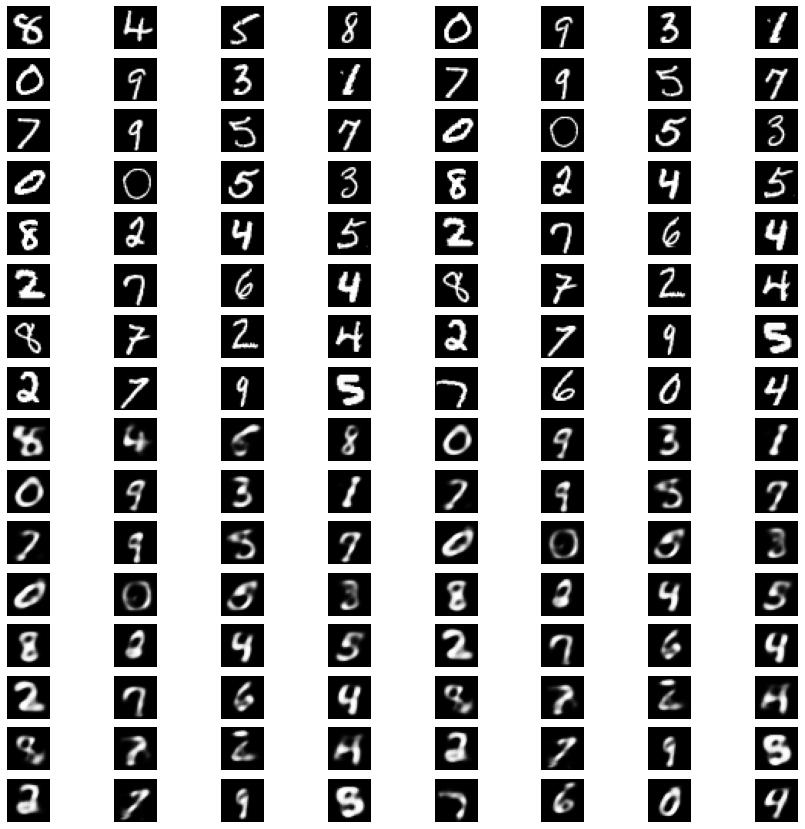


Min Loss:122.0976
model saved
Epoch : 50 
Train loss : 123.360442 
Validation loss : 122.097606

Min Loss:121.9999
model saved
Epoch : 51 
Train loss : 123.360008 
Validation loss : 121.999872
Epoch : 52 
Train loss : 123.283260 
Validation loss : 122.049310

Min Loss:121.9174
model saved
Epoch : 53 
Train loss : 123.260871 
Validation loss : 121.917373
Epoch : 54 
Train loss : 123.217658 
Validation loss : 121.997726

Min Loss:121.7535
model saved
Epoch : 55 
Train loss : 123.145556 
Validation loss : 121.753493

Min Loss:121.5487
model saved
Epoch : 56 
Train loss : 122.958725 
Validation loss : 121.548685

Min Loss:121.4661
model saved
Epoch : 57 
Train loss : 122.740240 
Validation loss : 121.466090

Min Loss:121.2694
model saved
Epoch : 58 
Train loss : 122.602286 
Validation loss : 121.269444

Min Loss:121.1940
model saved
Epoch : 59 
Train loss : 122.523184 
Validation loss : 121.194048


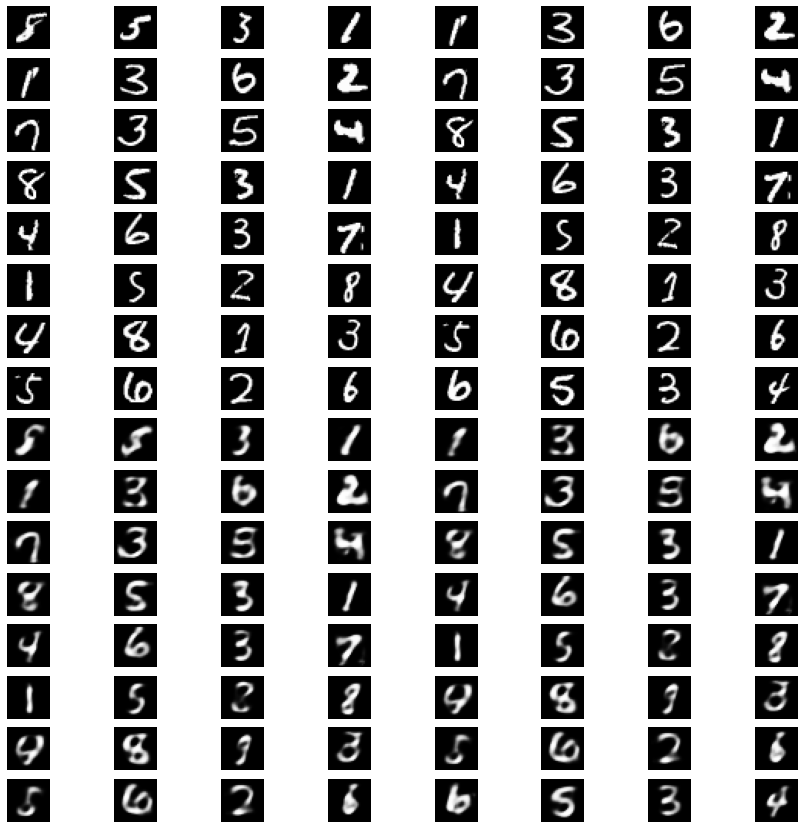


Min Loss:121.1453
model saved
Epoch : 60 
Train loss : 122.409123 
Validation loss : 121.145333

Min Loss:120.9189
model saved
Epoch : 61 
Train loss : 122.286851 
Validation loss : 120.918910

Min Loss:120.7175
model saved
Epoch : 62 
Train loss : 122.120632 
Validation loss : 120.717490

Min Loss:120.4417
model saved
Epoch : 63 
Train loss : 121.833963 
Validation loss : 120.441680

Min Loss:120.3016
model saved
Epoch : 64 
Train loss : 121.583377 
Validation loss : 120.301563

Min Loss:120.0158
model saved
Epoch : 65 
Train loss : 121.489565 
Validation loss : 120.015824

Min Loss:119.9477
model saved
Epoch : 66 
Train loss : 121.352555 
Validation loss : 119.947682

Min Loss:119.8338
model saved
Epoch : 67 
Train loss : 121.290991 
Validation loss : 119.833835
Epoch : 68 
Train loss : 121.159060 
Validation loss : 119.873071

Min Loss:119.7147
model saved
Epoch : 69 
Train loss : 121.096088 
Validation loss : 119.714685


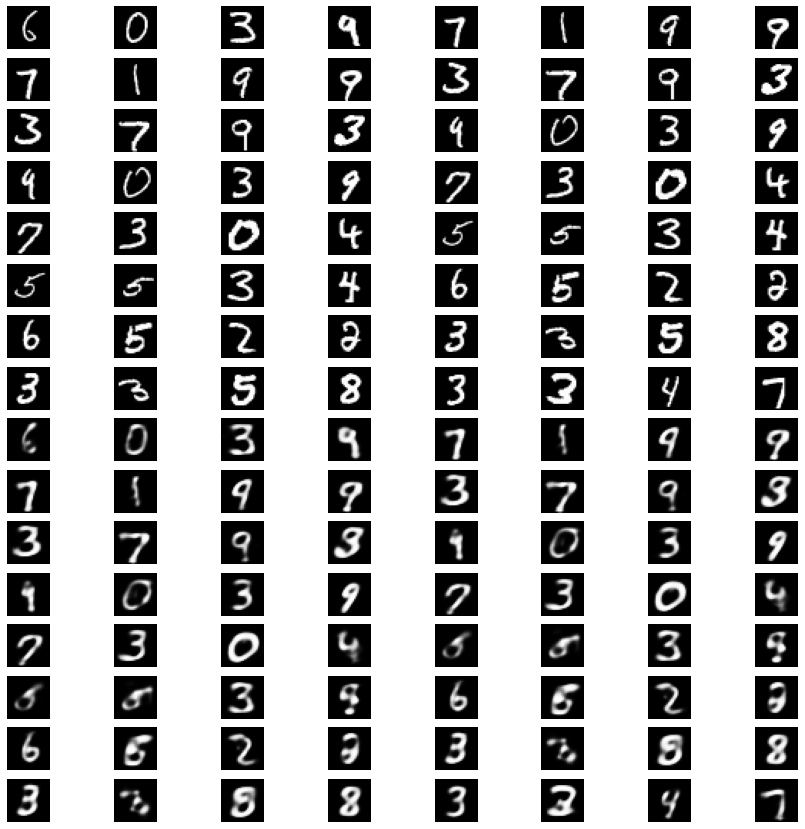


Min Loss:119.6636
model saved
Epoch : 70 
Train loss : 121.025790 
Validation loss : 119.663567
Epoch : 71 
Train loss : 120.960692 
Validation loss : 119.715968

Min Loss:119.5655
model saved
Epoch : 72 
Train loss : 120.935387 
Validation loss : 119.565521
Epoch : 73 
Train loss : 120.897223 
Validation loss : 119.598331
Epoch : 74 
Train loss : 120.876652 
Validation loss : 119.723915
Epoch : 75 
Train loss : 120.843600 
Validation loss : 119.625810

Min Loss:119.5560
model saved
Epoch : 76 
Train loss : 120.852822 
Validation loss : 119.556031

Min Loss:119.5443
model saved
Epoch : 77 
Train loss : 120.820848 
Validation loss : 119.544301

Min Loss:119.4338
model saved
Epoch : 78 
Train loss : 120.821390 
Validation loss : 119.433764
Epoch : 79 
Train loss : 120.770906 
Validation loss : 119.544317


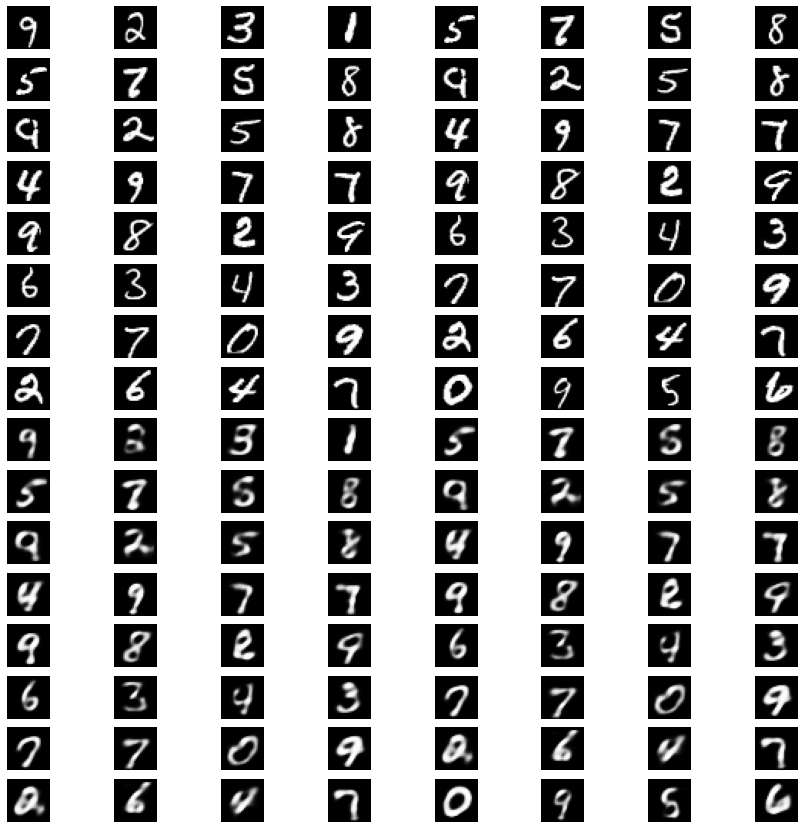

Epoch : 80 
Train loss : 120.751662 
Validation loss : 119.461415

Min Loss:119.4231
model saved
Epoch : 81 
Train loss : 120.756469 
Validation loss : 119.423093
Epoch : 82 
Train loss : 120.770756 
Validation loss : 119.423287

Min Loss:119.3392
model saved
Epoch : 83 
Train loss : 120.738371 
Validation loss : 119.339216
Epoch : 84 
Train loss : 120.701711 
Validation loss : 119.455019
Epoch : 85 
Train loss : 120.692015 
Validation loss : 119.453568
Epoch : 86 
Train loss : 120.666600 
Validation loss : 119.349171
Current learning rate is: 8e-05
Epoch : 87 
Train loss : 120.672034 
Validation loss : 119.410987

Min Loss:119.3251
model saved
Epoch : 88 
Train loss : 120.587137 
Validation loss : 119.325132
Epoch : 89 
Train loss : 120.582148 
Validation loss : 119.325993


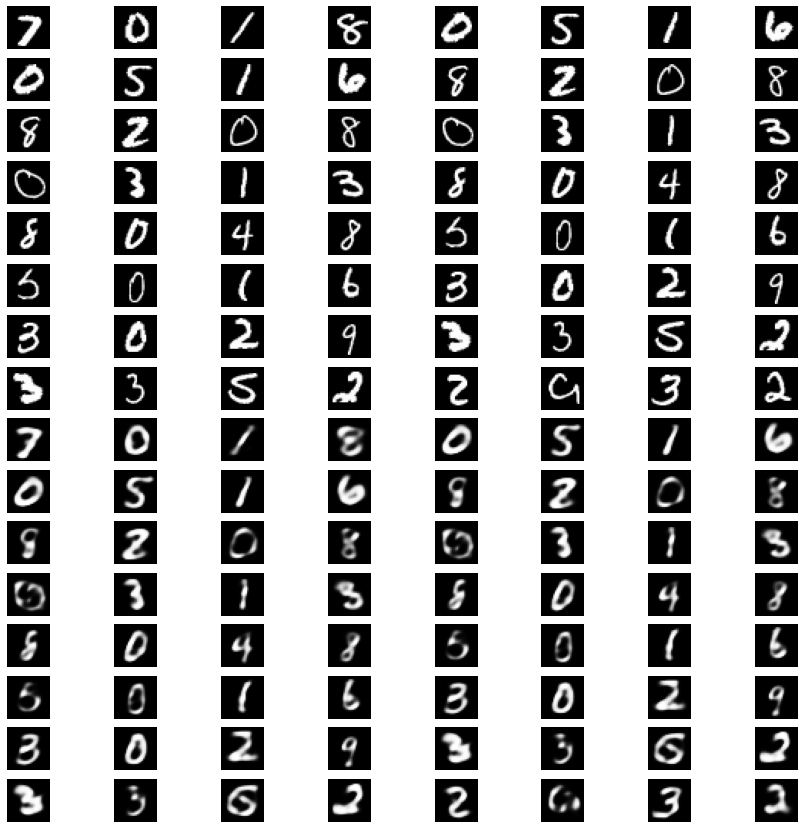


Min Loss:119.2883
model saved
Epoch : 90 
Train loss : 120.567676 
Validation loss : 119.288306

Min Loss:119.2722
model saved
Epoch : 91 
Train loss : 120.559738 
Validation loss : 119.272159
Epoch : 92 
Train loss : 120.584079 
Validation loss : 119.317698

Min Loss:119.1909
model saved
Epoch : 93 
Train loss : 120.559371 
Validation loss : 119.190921
Epoch : 94 
Train loss : 120.545877 
Validation loss : 119.381604
Epoch : 95 
Train loss : 120.551015 
Validation loss : 119.322441
Epoch : 96 
Train loss : 120.518459 
Validation loss : 119.333910
Current learning rate is: 6.400000000000001e-05
Epoch : 97 
Train loss : 120.525680 
Validation loss : 119.235964

Min Loss:119.1513
model saved
Epoch : 98 
Train loss : 120.485050 
Validation loss : 119.151306
Epoch : 99 
Train loss : 120.472477 
Validation loss : 119.233695


In [ ]:
model_1 = VAE(in_dim = 784,z_dim = 20).to(device)
epochs = 100
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
min_loss = 1e6
j = 1
L_recon =  nn.BCELoss(reduction='sum')
for epoch in range(epochs):
  train_loss = train_model(model_1)
  validation_loss = validate(model_1)
  print(f"Epoch : {epoch} \nTrain loss : {train_loss:.6f} \nValidation loss : {validation_loss:.6f}")

# UNet


In [ ]:

def crop(e,d):
  diff = e.size(2) - d.size(2)
  return e[:,:,diff//2:d.size(2)+diff//2 ,diff//2:d.size(2)+diff//2]

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    self.maxpool = nn.MaxPool2d(kernel_size=2 , stride = 2)
    self.encoder_conv_1 = nn.Sequential(nn.Conv2d(in_channels= 1, out_channels= 64 , kernel_size= 3),
                                 nn.ReLU(inplace= True),
                                 nn.Conv2d(in_channels= 64, out_channels= 64 , kernel_size= 3),
                                 nn.ReLU(inplace= True),
                                 )
    self.encoder_conv_2 = nn.Sequential(nn.Conv2d(in_channels= 64, out_channels= 128 , kernel_size= 3),
                                 nn.ReLU(inplace= True),
                                 nn.Conv2d(in_channels= 128, out_channels= 128 , kernel_size= 3),
                                 nn.ReLU(inplace= True),
                                 )
    self.encoder_conv_3 = nn.Sequential(nn.Conv2d(in_channels= 128, out_channels= 256 , kernel_size= 3),
                                 nn.ReLU(inplace= True),
                                 nn.Conv2d(in_channels= 256, out_channels= 256 , kernel_size= 3),
                                 nn.ReLU(inplace= True),
                                 )
    # self.encoder_conv_4 = nn.Sequential(nn.Conv2d(in_channels= 256, out_channels= 512 , kernel_size= 3),
    #                             nn.ReLU(inplace= True),
    #                              nn.Conv2d(in_channels= 512, out_channels= 512 , kernel_size= 3),
    #                              nn.ReLU(inplace= True),
    #                              )
    # self.encoder_conv_5 = nn.Sequential(nn.Conv2d(in_channels= 512, out_channels= 1024 , kernel_size= 3),
    #                              nn.ReLU(inplace= True),
    #                              nn.Conv2d(in_channels= 1024, out_channels= 1024 , kernel_size= 3),
    #                              nn.ReLU(inplace= True))    
    
    # self.convt_1= nn.ConvTranspose2d(in_channels = 512, out_channels = 512 , kernel_size=2 ,stride=2)
    # self.convt_2= nn.ConvTranspose2d(in_channels = 512, out_channels = 256 , kernel_size=2,stride=2)
    
    self.convt_3= nn.ConvTranspose2d(in_channels = 128, out_channels = 128 , kernel_size=2,stride=2)
    self.convt_4= nn.ConvTranspose2d(in_channels = 128, out_channels = 64 , kernel_size=2,stride=2)

    # self.decoder_conv_1 = nn.Sequential(nn.Conv2d(in_channels= 1024, out_channels= 512 , kernel_size= 3),
    #                                     nn.ReLU(inplace= True),
    #                                     nn.Conv2d(in_channels= 512, out_channels= 512 , kernel_size= 3),
    #                                     nn.ReLU(inplace= True),
    #                                     )
    # self.decoder_conv_2 = nn.Sequential(nn.Conv2d(in_channels= 512, out_channels= 256 , kernel_size= 3),
    #                                     nn.ReLU(inplace= True),
    #                                     nn.Conv2d(in_channels= 256, out_channels= 256 , kernel_size= 3),
    #                                     nn.ReLU(inplace= True),
    #                                     )
    self.decoder_conv_3 = nn.Sequential(nn.Conv2d(in_channels= 256, out_channels= 128 , kernel_size= 3),
                                        nn.ReLU(inplace= True),
                                        nn.Conv2d(in_channels= 128, out_channels= 128 , kernel_size= 3),
                                        nn.ReLU(inplace= True),
                                        )
    self.decoder_conv_4 = nn.Sequential(nn.Conv2d(in_channels= 128, out_channels= 64 , kernel_size= 3),
                                        nn.ReLU(inplace= True),
                                        nn.Conv2d(in_channels= 64, out_channels= 64 , kernel_size= 3),
                                        nn.ReLU(inplace= True),
                                        )
    self.decoder_conv_5 = nn.Conv2d(in_channels= 64, out_channels= 1 , kernel_size= 1)
                                      
  def forward(self,x):
      e1 = self.encoder_conv_1(x)
      e2 = self.encoder_conv_2(self.maxpool(e1))
      e3 = self.encoder_conv_3(self.maxpool(e2))
      # e4 = self.encoder_conv_4(self.maxpool(e3))
      # e5 = self.encoder_conv_5(self.maxpool(e4))
      # e5 = e5.view(e5.size(0),2,512,e5.size(2),e5.size(3))
      # mu = e5[:,0,:]
      # log_sigma = e5[:,1,:]


      e3 = e3.view(e3.size(0),2,128,e3.size(2),e3.size(3))
      mu = e3[:,0,:]
      log_sigma = e3[:,1,:]

      z = mu + torch.randn_like(mu) * torch.exp(log_sigma) 
      # z = self.decoder_conv_1(torch.cat((self.convt_1(z),crop(e4,self.convt_1(z))),1))
      # z = self.decoder_conv_2(torch.cat((self.convt_2(z),crop(e3,self.convt_2(z))),1))
      z = self.decoder_conv_3(torch.cat((self.convt_3(z),crop(e2,self.convt_3(z))),1))
      z = self.decoder_conv_4(torch.cat((self.convt_4(z),crop(e1,self.convt_4(z))),1))
      z = self.decoder_conv_5(z)
      z = torch.sigmoid(F.interpolate(z, size=x.shape[-2:], mode='bilinear', align_corners=False))
      return z , mu , log_sigma

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((54,54))
                                ])
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = datasets.MNIST(root='../input/data',train=True,download=True,transform=transform)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_data = datasets.MNIST(root='../input/data',train=False,download=True,transform=transform)
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle=False)

Extracting ../input/data/MNIST/raw/train-images-idx3-ubyte.gz to ../input/data/MNIST/raw


Extracting ../input/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/data/MNIST/raw


Extracting ../input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/data/MNIST/raw


Extracting ../input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/data/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


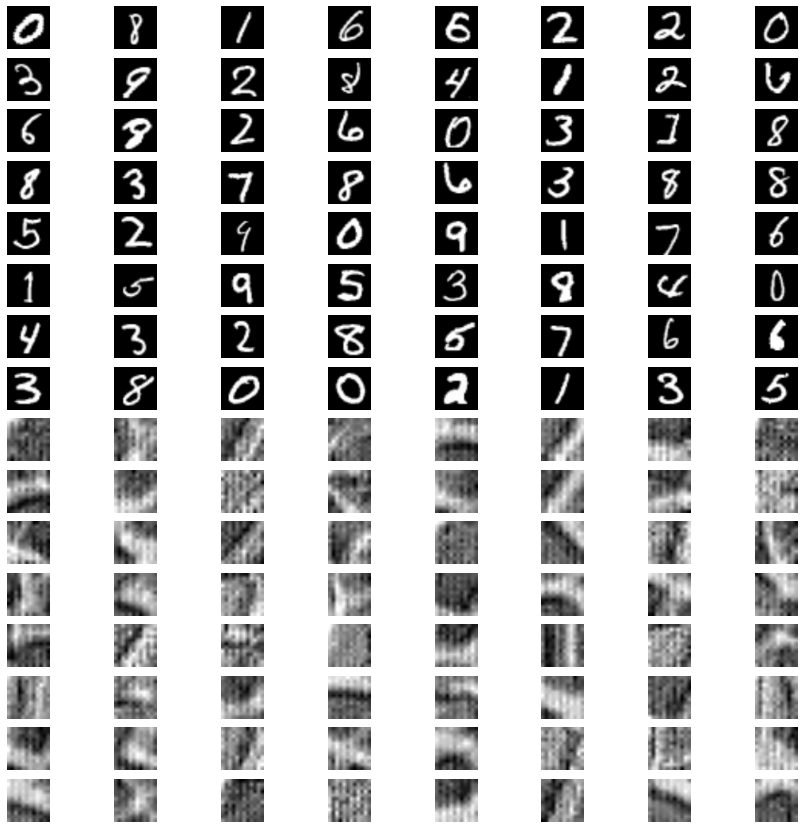


Min Loss:915.7521
model saved
Epoch : 0 
Train loss : 1057.785339 
Validation loss : 915.752080

Min Loss:761.9390
model saved
Epoch : 1 
Train loss : 839.047070 
Validation loss : 761.939035

Min Loss:645.5508
model saved
Epoch : 2 
Train loss : 706.631568 
Validation loss : 645.550762

Min Loss:581.3218
model saved
Epoch : 3 
Train loss : 622.299557 
Validation loss : 581.321764

Min Loss:538.4559
model saved
Epoch : 4 
Train loss : 564.257876 
Validation loss : 538.455887

Min Loss:492.3524
model saved
Epoch : 5 
Train loss : 517.808458 
Validation loss : 492.352361

Min Loss:469.5217
model saved
Epoch : 6 
Train loss : 485.133907 
Validation loss : 469.521687

Min Loss:443.6170
model saved
Epoch : 7 
Train loss : 458.321479 
Validation loss : 443.616966

Min Loss:423.1769
model saved
Epoch : 8 
Train loss : 442.011263 
Validation loss : 423.176929

Min Loss:409.2959
model saved
Epoch : 9 
Train loss : 425.532751 
Validation loss : 409.295874


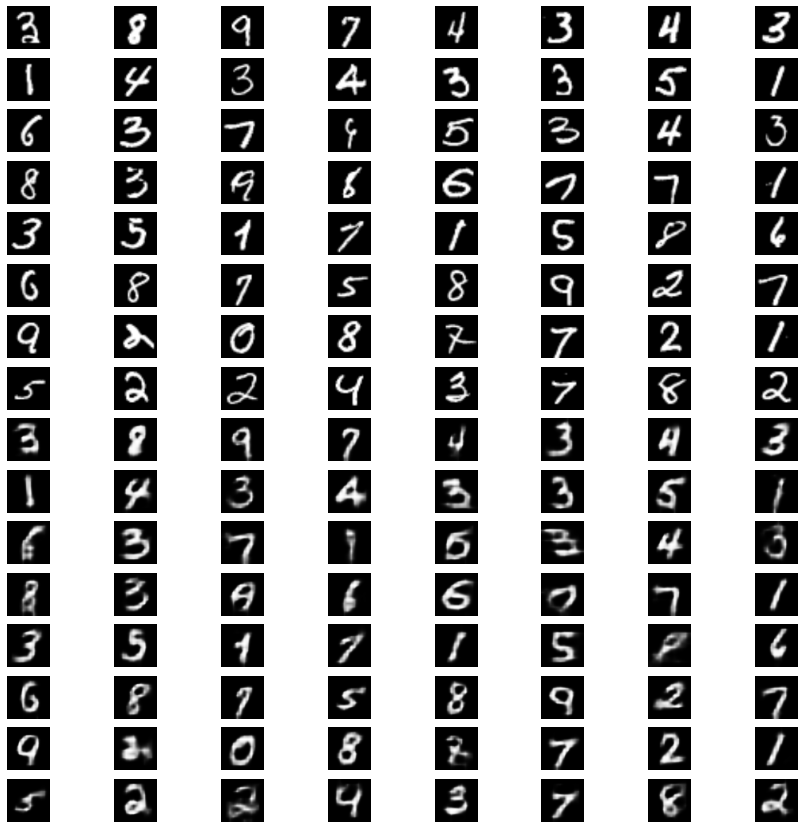

Epoch : 10 
Train loss : 411.903961 
Validation loss : 411.457961

Min Loss:390.6835
model saved
Epoch : 11 
Train loss : 407.069857 
Validation loss : 390.683479

Min Loss:386.2007
model saved
Epoch : 12 
Train loss : 396.798856 
Validation loss : 386.200748
Epoch : 13 
Train loss : 386.750293 
Validation loss : 395.498947

Min Loss:372.5684
model saved
Epoch : 14 
Train loss : 385.905808 
Validation loss : 372.568353

Min Loss:368.8872
model saved
Epoch : 15 
Train loss : 380.565428 
Validation loss : 368.887209

Min Loss:367.1226
model saved
Epoch : 16 
Train loss : 373.582043 
Validation loss : 367.122572

Min Loss:362.5149
model saved
Epoch : 17 
Train loss : 374.865905 
Validation loss : 362.514861

Min Loss:359.0464
model saved
Epoch : 18 
Train loss : 366.989789 
Validation loss : 359.046421

Min Loss:357.5611
model saved
Epoch : 19 
Train loss : 370.473723 
Validation loss : 357.561147


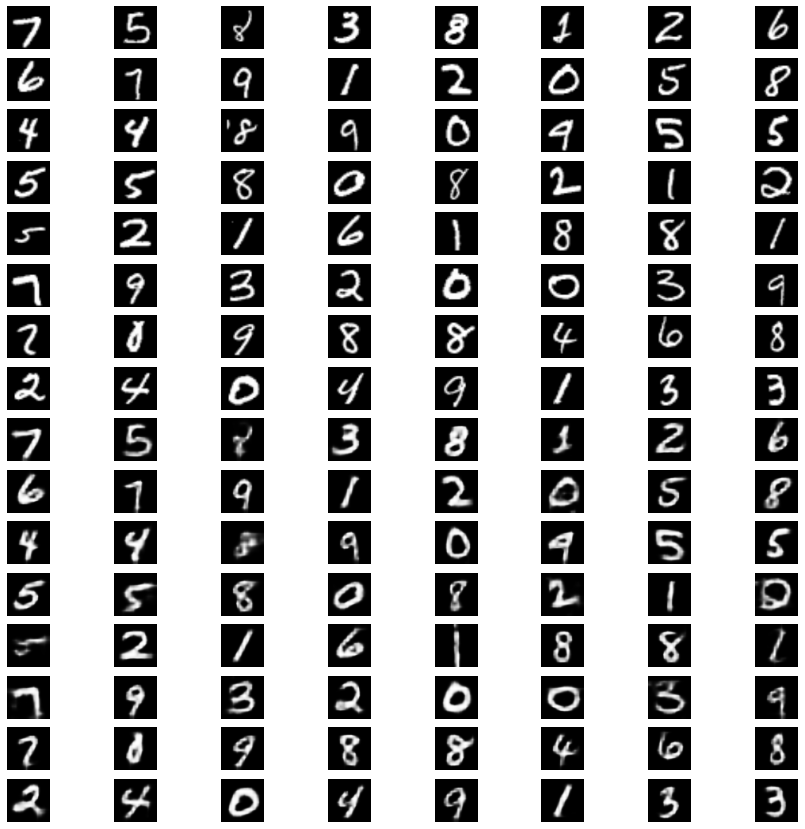


Min Loss:356.4134
model saved
Epoch : 20 
Train loss : 359.054846 
Validation loss : 356.413392

Min Loss:352.1993
model saved
Epoch : 21 
Train loss : 358.956787 
Validation loss : 352.199304

Min Loss:351.7655
model saved
Epoch : 22 
Train loss : 361.659682 
Validation loss : 351.765524

Min Loss:348.7952
model saved
Epoch : 23 
Train loss : 355.000830 
Validation loss : 348.795220

Min Loss:346.6261
model saved
Epoch : 24 
Train loss : 353.696159 
Validation loss : 346.626051
Epoch : 25 
Train loss : 357.341570 
Validation loss : 346.695590

Min Loss:343.7334
model saved
Epoch : 26 
Train loss : 353.739750 
Validation loss : 343.733450

Min Loss:342.6920
model saved
Epoch : 27 
Train loss : 352.568192 
Validation loss : 342.691997

Min Loss:341.1107
model saved
Epoch : 28 
Train loss : 348.630887 
Validation loss : 341.110670

Min Loss:340.2880
model saved
Epoch : 29 
Train loss : 346.151687 
Validation loss : 340.287999


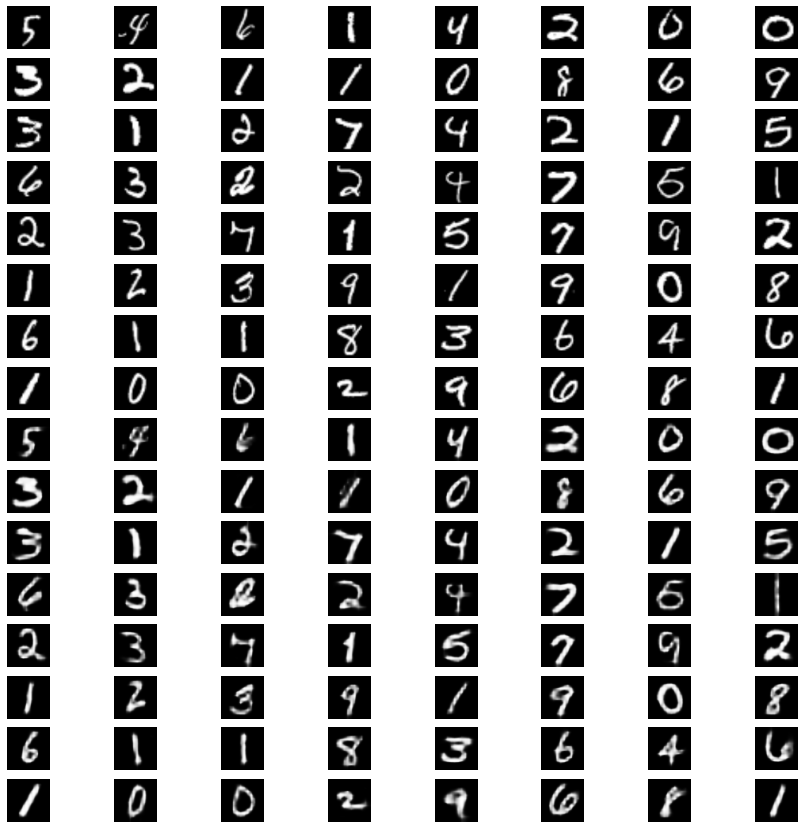

Epoch : 30 
Train loss : 344.777584 
Validation loss : 340.304790
Epoch : 31 
Train loss : 344.021529 
Validation loss : 343.700826

Min Loss:337.1353
model saved
Epoch : 32 
Train loss : 345.276865 
Validation loss : 337.135261
Epoch : 33 
Train loss : 342.538408 
Validation loss : 349.722563

Min Loss:336.5701
model saved
Epoch : 34 
Train loss : 341.719116 
Validation loss : 336.570076
Epoch : 35 
Train loss : 338.230791 
Validation loss : 425.745437
Epoch : 36 
Train loss : 342.864822 
Validation loss : 337.321206
Epoch : 37 
Train loss : 344.836564 
Validation loss : 339.068175

Min Loss:333.2029
model saved
Epoch : 38 
Train loss : 339.698233 
Validation loss : 333.202948
Epoch : 39 
Train loss : 335.674439 
Validation loss : 333.414283


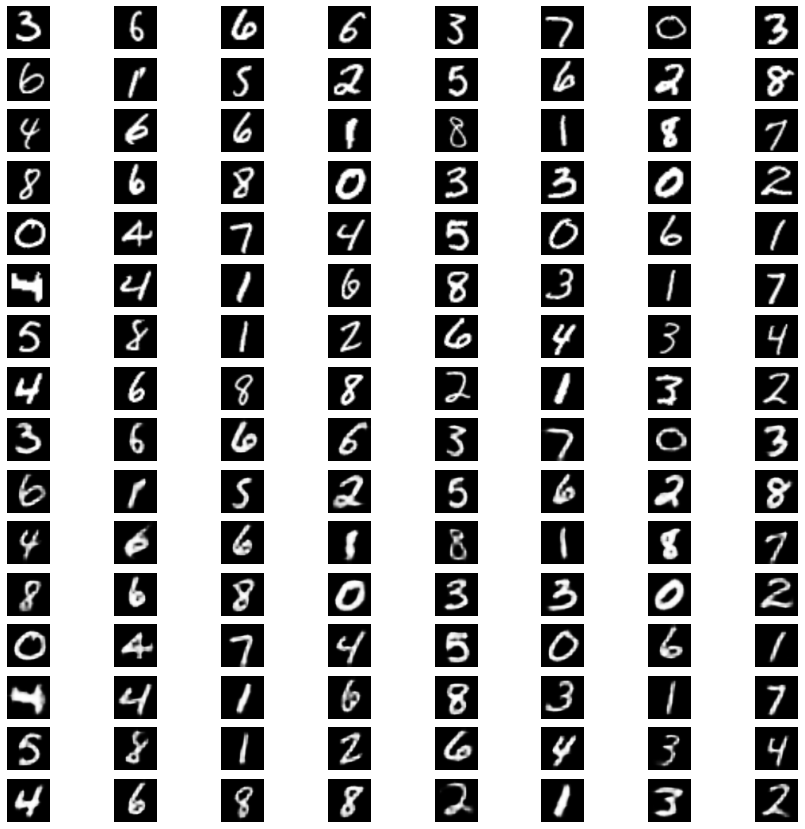


Min Loss:332.6979
model saved
Epoch : 40 
Train loss : 337.033255 
Validation loss : 332.697922
Epoch : 41 
Train loss : 334.317161 
Validation loss : 333.707830

Min Loss:330.2823
model saved
Epoch : 42 
Train loss : 337.956523 
Validation loss : 330.282317
Epoch : 43 
Train loss : 337.647502 
Validation loss : 332.926411

Min Loss:330.2273
model saved
Epoch : 44 
Train loss : 332.679758 
Validation loss : 330.227268

Min Loss:329.8748
model saved
Epoch : 45 
Train loss : 333.566161 
Validation loss : 329.874817

Min Loss:328.9478
model saved
Epoch : 46 
Train loss : 331.455774 
Validation loss : 328.947787

Min Loss:327.2156
model saved
Epoch : 47 
Train loss : 333.678933 
Validation loss : 327.215629
Epoch : 48 
Train loss : 331.493862 
Validation loss : 329.752856
Epoch : 49 
Train loss : 333.160016 
Validation loss : 327.794143


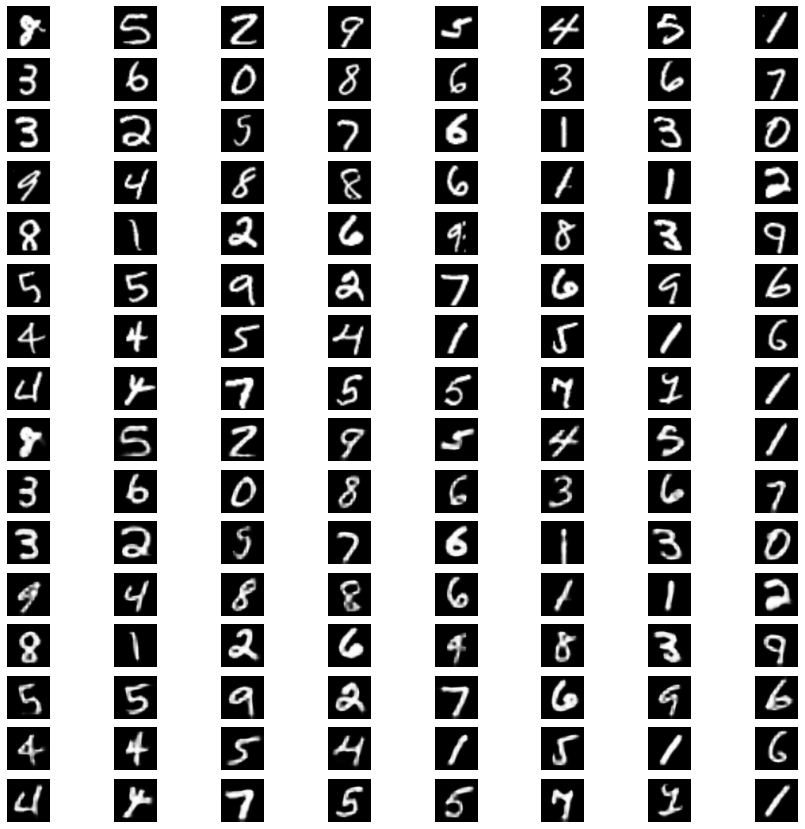


Min Loss:326.4486
model saved
Epoch : 50 
Train loss : 331.380974 
Validation loss : 326.448572
Epoch : 51 
Train loss : 330.456285 
Validation loss : 344.889769

Min Loss:326.3274
model saved
Epoch : 52 
Train loss : 330.782687 
Validation loss : 326.327445
Epoch : 53 
Train loss : 327.692624 
Validation loss : 327.007972

Min Loss:325.5026
model saved
Epoch : 54 
Train loss : 331.557376 
Validation loss : 325.502602
Epoch : 55 
Train loss : 328.041331 
Validation loss : 327.967694

Min Loss:324.8064
model saved
Epoch : 56 
Train loss : 328.389679 
Validation loss : 324.806400
Epoch : 57 
Train loss : 329.909812 
Validation loss : 325.170209

Min Loss:323.9177
model saved
Epoch : 58 
Train loss : 325.681363 
Validation loss : 323.917680
Epoch : 59 
Train loss : 326.368382 
Validation loss : 466.933313


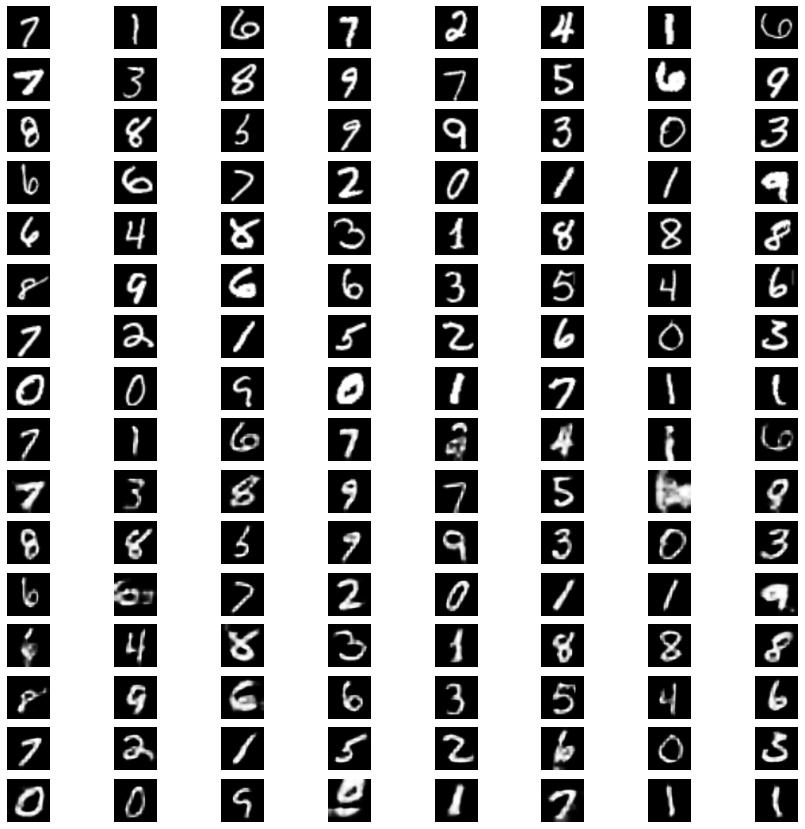

Epoch : 60 
Train loss : 326.919026 
Validation loss : 324.151614
Epoch : 61 
Train loss : 327.499075 
Validation loss : 324.609089

Min Loss:322.2163
model saved
Epoch : 62 
Train loss : 324.590970 
Validation loss : 322.216300

Min Loss:322.1234
model saved
Epoch : 63 
Train loss : 324.755569 
Validation loss : 322.123350

Min Loss:321.6711
model saved
Epoch : 64 
Train loss : 325.574402 
Validation loss : 321.671147

Min Loss:320.9945
model saved
Epoch : 65 
Train loss : 323.185234 
Validation loss : 320.994472
Epoch : 66 
Train loss : 326.256405 
Validation loss : 322.157476

Min Loss:320.3685
model saved
Epoch : 67 
Train loss : 322.971151 
Validation loss : 320.368524
Epoch : 68 
Train loss : 323.260687 
Validation loss : 321.190106
Epoch : 69 
Train loss : 323.542767 
Validation loss : 320.850175


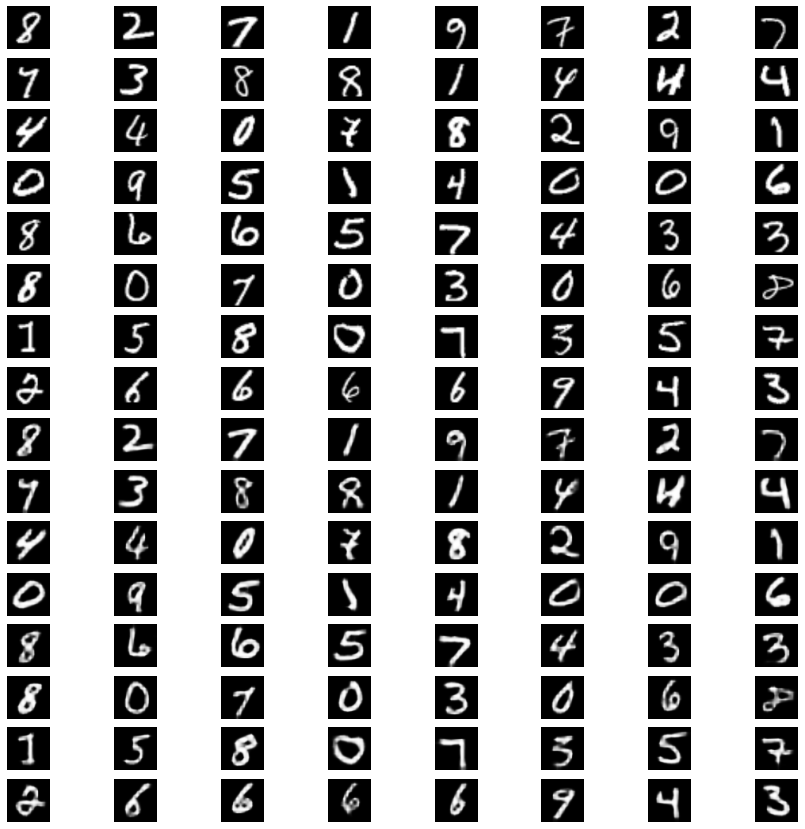

Epoch : 70 
Train loss : 323.858667 
Validation loss : 320.546500
Current learning rate is: 8e-05
Epoch : 71 
Train loss : 321.662892 
Validation loss : 320.424550

Min Loss:319.1503
model saved
Epoch : 72 
Train loss : 321.166313 
Validation loss : 319.150296

Min Loss:318.5468
model saved
Epoch : 73 
Train loss : 320.788396 
Validation loss : 318.546841

Min Loss:318.2210
model saved
Epoch : 74 
Train loss : 321.670934 
Validation loss : 318.221046
Epoch : 75 
Train loss : 320.460542 
Validation loss : 318.728325

Min Loss:318.0525
model saved
Epoch : 76 
Train loss : 324.460253 
Validation loss : 318.052460

Min Loss:317.6744
model saved
Epoch : 77 
Train loss : 319.522885 
Validation loss : 317.674416

Min Loss:317.5945
model saved
Epoch : 78 
Train loss : 319.378452 
Validation loss : 317.594545

Min Loss:317.4287
model saved
Epoch : 79 
Train loss : 319.689207 
Validation loss : 317.428688


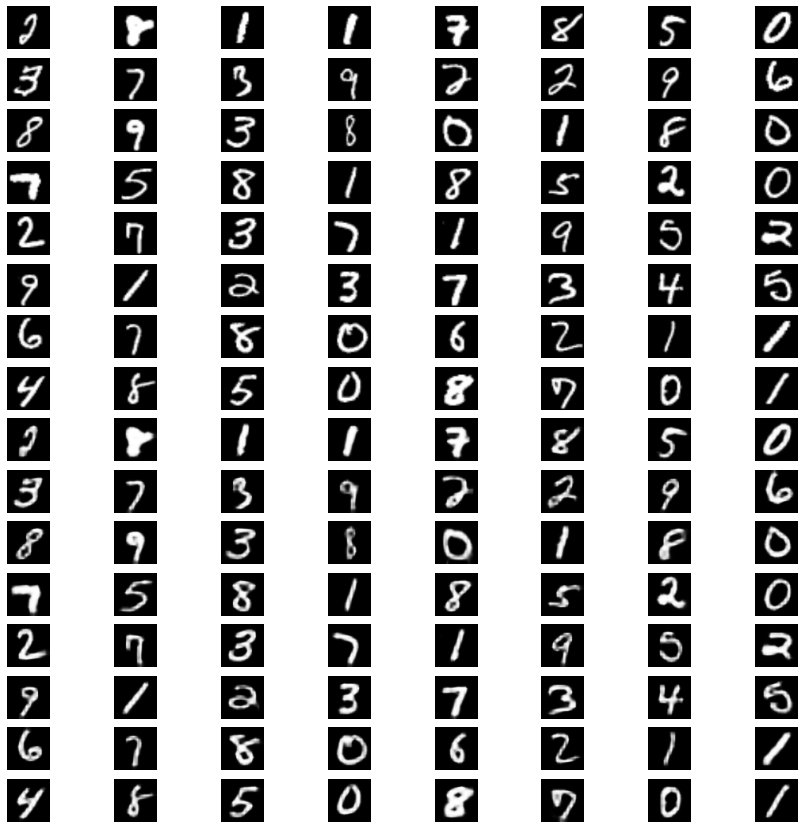

Epoch : 80 
Train loss : 319.454862 
Validation loss : 317.954446
Epoch : 81 
Train loss : 319.322375 
Validation loss : 318.210793
Epoch : 82 
Train loss : 321.049963 
Validation loss : 318.193028

Min Loss:317.0875
model saved
Epoch : 83 
Train loss : 318.337794 
Validation loss : 317.087538

Min Loss:316.1995
model saved
Epoch : 84 
Train loss : 318.140418 
Validation loss : 316.199469
Epoch : 85 
Train loss : 318.190054 
Validation loss : 316.337738
Epoch : 86 
Train loss : 318.049479 
Validation loss : 317.842933
Epoch : 87 
Train loss : 317.830960 
Validation loss : 316.216609

Min Loss:315.4468
model saved
Epoch : 88 
Train loss : 320.756815 
Validation loss : 315.446812
Epoch : 89 
Train loss : 316.938397 
Validation loss : 315.692312


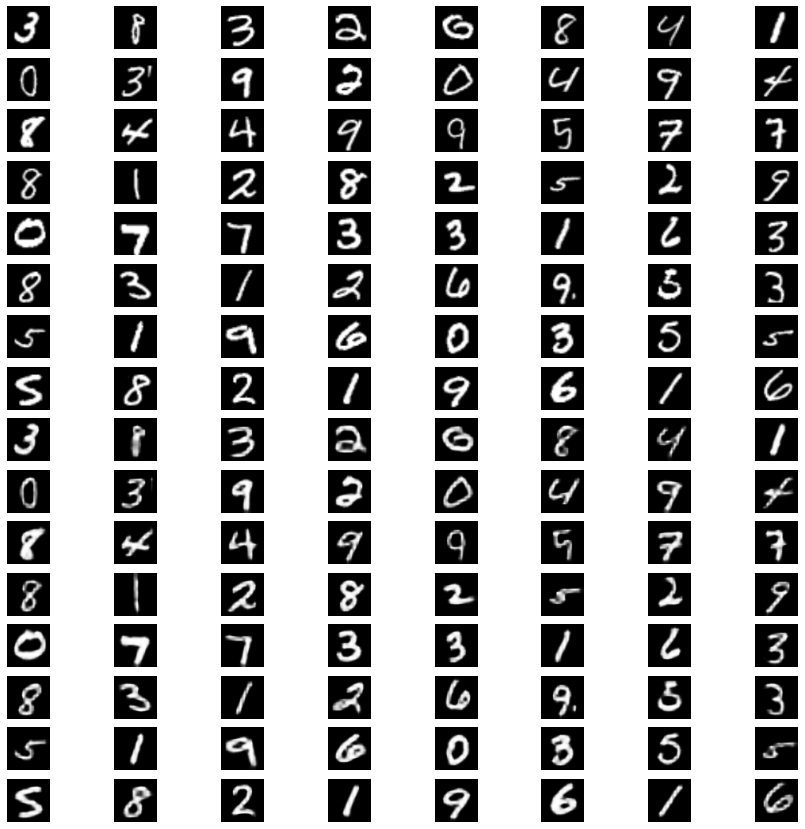

Epoch : 90 
Train loss : 317.058721 
Validation loss : 315.871737

Min Loss:315.1487
model saved
Epoch : 91 
Train loss : 316.906913 
Validation loss : 315.148652
Epoch : 92 
Train loss : 316.825849 
Validation loss : 316.093112

Min Loss:314.8358
model saved
Epoch : 93 
Train loss : 317.713664 
Validation loss : 314.835824
Epoch : 94 
Train loss : 316.345819 
Validation loss : 315.226289

Min Loss:314.5865
model saved
Epoch : 95 
Train loss : 316.350652 
Validation loss : 314.586540
Epoch : 96 
Train loss : 316.148506 
Validation loss : 315.995286

Min Loss:314.2341
model saved
Epoch : 97 
Train loss : 317.812954 
Validation loss : 314.234111
Epoch : 98 
Train loss : 315.404517 
Validation loss : 314.293429

Min Loss:313.4903
model saved
Epoch : 99 
Train loss : 315.376951 
Validation loss : 313.490344


In [ ]:
model_2 = UNet().to(device)
epochs = 100
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
L_recon =  nn.BCELoss(reduction='sum')
min_loss = 1e6
j = 1
for epoch in range(epochs):
  train_loss = train_model(model_2)
  validation_loss = validate(model_2)
  print(f"Epoch : {epoch} \nTrain loss : {train_loss:.6f} \nValidation loss : {validation_loss:.6f}")